In [18]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Retrieving and processing data

In [19]:
data = pd.read_csv("data/one_hot_enc.csv")
data.head()

,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,...,LSH 602_IsSystem,LSH 602_Value,LSH 603_IsSystem,LSH 603_Value,LSL 601_IsSystem,LSL 601_Value,LSL 602_IsSystem,LSL 602_Value,LSL 603_IsSystem,LSL 603_Value
0,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,...,False,1,False,0,False,0,False,0,False,1
1,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,...,False,1,False,0,False,0,False,0,False,1
2,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,...,False,1,False,0,False,0,False,0,False,1
3,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,...,False,1,False,0,False,0,False,0,False,1
4,0,0.0,727.7069,1,3,2,1,142.527557,9.289157,198.897720,...,False,1,False,0,False,0,False,0,False,1


In [25]:
X = data.drop('Label', axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((10497, 88), (4499, 88))

# Defining different classifier

In [26]:
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
mlp = MLPClassifier(random_state=42, max_iter=200)

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
mlp.fit(X_train, y_train)

dt_preds = dt.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)
mlp_preds = mlp.predict(X_test)

dt_acc = accuracy_score(y_test, dt_preds)
rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
mlp_acc = accuracy_score(y_test, mlp_preds)

dt_acc, rf_acc, xgb_acc, mlp_acc

(0.9988886419204268,
 0.9991109135363414,
 0.9991109135363414,
 0.9991109135363414)

# Analyzing results accuracy

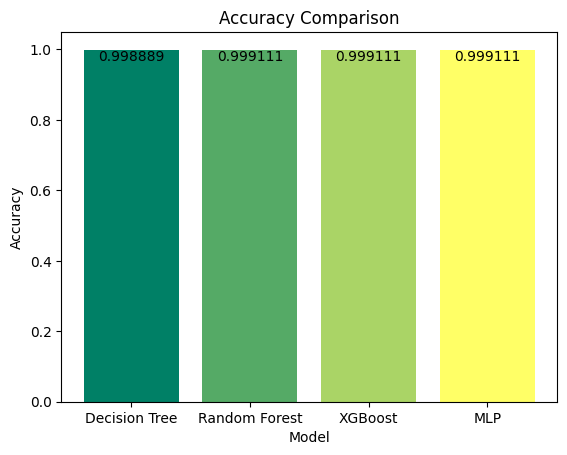

In [27]:
models = ['Decision Tree', 'Random Forest', 'XGBoost', 'MLP']
accuracies = [dt_acc, rf_acc, xgb_acc, mlp_acc]

sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

colors = plt.cm.summer(np.linspace(0, 1, len(sorted_accuracies)))

plt.bar(sorted_models, sorted_accuracies, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

for i, acc in enumerate(sorted_accuracies):
    plt.text(i, acc, f'{acc:.6f}', ha='center', va='top')

plt.show()

On remarque que les 4 classifieurs ont de très bon résultats étant quasiment identique et identifiant presque toutes les attaques.

# Gain d’information associé à XGBoost

In [59]:
# Obtention de l'importance des caractéristiques
feature_importance_xgb = xgb.feature_importances_
feature_importance_dt = dt.feature_importances_
feature_importance_rf = rf.feature_importances_
feature_importance_mlp = mlp.coefs_

# Associer les noms des caractéristiques à leur importance
feature_names = data.drop('Label', axis=1).columns
feature_importance_mapping_xgb = dict(zip(feature_names, feature_importance_xgb))
feature_importance_mapping_dt = dict(zip(feature_names, feature_importance_dt))
feature_importance_mapping_rf = dict(zip(feature_names, feature_importance_rf))

# Trier les caractéristiques par importance
sorted_feature_importance_xgb = sorted(feature_importance_mapping_xgb.items(), key=lambda x: x[1], reverse=True)
sorted_feature_importance_dt = sorted(feature_importance_mapping_dt.items(), key=lambda x: x[1], reverse=True)
sorted_feature_importance_rf = sorted(feature_importance_mapping_rf.items(), key=lambda x: x[1], reverse=True)

# Affichage des 5 premieres caractéristiques et de leur importance
table = pd.DataFrame(columns=['XGBoost', 'xgb_importance', 'Decision Tree', 'dt_importance', 'Random Forest', 'rf_importance'])
for i in range(5):
    table.loc[i] = [sorted_feature_importance_xgb[i][0], sorted_feature_importance_xgb[i][1],
                    sorted_feature_importance_dt[i][0], sorted_feature_importance_dt[i][1],
                    sorted_feature_importance_rf[i][0], sorted_feature_importance_rf[i][1]]
table

,XGBoost,xgb_importance,Decision Tree,dt_importance,Random Forest,rf_importance
0,AIT 201,0.294312,AIT 201,0.377763,LIT 301,0.110238
1,AIT 402,0.151968,LIT 301,0.208434,AIT 202,0.094160
2,PIT 502,0.099888,AIT 202,0.100996,AIT 201,0.079415
3,FIT 502,0.067668,AIT 301,0.075601,AIT 402,0.057391
4,P101 Status,0.057463,P101 Status,0.068292,AIT 502,0.049786


XGboost étant censé être le meilleur classifieur pour ce type de problème, on remarque que l'importance majeure est donnée à la colonne 'AIT 201' et 'AIT 402'.

Etudions les deux colonnes portant le plus d'importance:

In [57]:
table = pd.DataFrame(columns=['mean', 'std', 'min', '25%', '50%', '75%', 'max'])
table.loc['Benign AIT 201'] = data[data['Label'] == 0]['AIT 201'].describe()
table.loc['Malicious AIT 201'] = data[data['Label'] == 1]['AIT 201'].describe()
table.loc['Benign AIT 402'] = data[data['Label'] == 0]['AIT 402'].describe()
table.loc['Malicious AIT 402'] = data[data['Label'] == 1]['AIT 402'].describe()
table

,mean,std,min,25%,50%,75%,max
Benign AIT 201,140.679854,7.059807,113.849014,143.136368,143.809280,144.033585,146.821335
Malicious AIT 201,129.441057,7.322331,115.130737,128.268387,128.492691,128.524734,144.321976
Benign AIT 402,15.957077,14.804846,3.332479,7.177647,10.843373,17.764675,87.951805
Malicious AIT 402,4.653923,1.059267,3.537555,3.870802,3.998975,4.896181,7.382722


On remarque de grande différence dans l'analyse des valeurs de ces deux colonnes entre les attaques et les non-attaques. On peut donc en déduire que ces deux colonnes sont très importantes pour la détection d'attaque.

Etudions maintenant une colonne qui n'a pas d'importance tel que P301 Status:

In [60]:
# P301 Status
table = pd.DataFrame(columns=['mean', 'std', 'min', '25%', '50%', '75%', 'max'])
table.loc['Benign P301 Status'] = data[data['Label'] == 0]['P301 Status'].describe()
table.loc['Malicious P301 Status'] = data[data['Label'] == 1]['P301 Status'].describe()
table

,mean,std,min,25%,50%,75%,max
Benign P301 Status,1.481395,0.499674,1.0,1.0,1.0,2.0,2.0
Malicious P301 Status,1.458676,0.498387,1.0,1.0,1.0,2.0,2.0


Aucune différence n'est visible entre les attaques et les non-attaques. On peut donc en déduire que cette colonne n'est pas importante pour la détection d'attaque.